In [1]:
import numpy as np

In [9]:
OFF = np.genfromtxt(r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\OPTIMUM\TXT\OFF_Phase.txt')

In [10]:
import matplotlib.pyplot as plt

In [11]:
from scipy.stats import poisson, norm

def compute_sum_poisson_gaussian(amplitudes, A, mu, delta, sigma, Egamma):
    """
    Compute the sum over n of P(n; µ)·G(OFF; nEγ + delta; σ)
    
    Parameters:
    - amplitudes: Array of measured amplitudes (OFF).
    - N: Maximum number of photons to consider.
    - mu: Mean of the Poisson distribution.
    - delta: Offset for the Gaussian distribution.
    - sigma: Standard deviation of the Gaussian distribution.
    - Egamma: Energy of a single photon.
    
    Returns:
    - Array of computed values for the given amplitudes.
    """
    # Initialize result array
    result = np.zeros_like(amplitudes)

    N = 200 
    
    # Array of possible photon numbers
    photon_numbers = np.arange(0, N+1, dtype=int)
    
    # Compute Poisson probabilities for all photon numbers
    poisson_probs = poisson.pmf(photon_numbers, mu)
    
    # Compute the Gaussian PDF for each photon number and sum up
    for i, n in enumerate(photon_numbers):
        # Compute Gaussian PDF for the current number of photons
        gaussian_values = norm.pdf(amplitudes, loc=n * Egamma + delta, scale=sigma)
        
        # Update result array
        result += poisson_probs[i] * gaussian_values
    
    return A * result

In [153]:
from scipy.stats import poisson, norm

def compute_sum_poisson_gaussian_2(amplitudes, A, mu, b, sigma, delta):
    """
    Compute the sum over n of P(n; µ)·G(OFF; nEγ + delta; σ)
    
    Parameters:
    - amplitudes: Array of measured amplitudes (OFF).
    - N: Maximum number of photons to consider.
    - mu: Mean of the Poisson distribution.
    - delta: Offset for the Gaussian distribution.
    - sigma: Standard deviation of the Gaussian distribution.
    - Egamma: Energy of a single photon.
    
    Returns:
    - Array of computed values for the given amplitudes.
    """
    # Initialize result array
    result = np.zeros_like(amplitudes)

    N = 640
    
    # Array of possible photon numbers
    photon_numbers = np.arange(0, N+1, dtype=int)
    
    # Compute Poisson probabilities for all photon numbers
    poisson_probs = poisson.pmf(photon_numbers, mu)
    
    # Compute the Gaussian PDF for each photon number and sum up
    for i, n in enumerate(photon_numbers):
        # Compute Gaussian PDF for the current number of photons
        gaussian_values = norm.pdf(amplitudes, loc=n*b-delta, scale=sigma)
        
        # Update result array
        result += poisson_probs[i] * gaussian_values
    
    return A * result

In [25]:
def plot(OFF, bin_centers,hist, m, func):
    idx = OFF > 0.037
    fig = plt.figure(figsize=(15, 6))
    fig.tight_layout()
    plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')
    plt.errorbar(bin_centers, func(bin_centers,*m.values),np.sqrt(func(bin_centers,*m.values)), fmt='ko',color='black',linestyle='-', label='MIGRAD',alpha=0.8)
    plt.hist(OFF[idx],80,histtype='bar',color='lightblue',density=False,alpha=0.5)
    plt.xlabel('Energy [eV]')
    plt.ylabel('Counts')
    plt.title('Histogram and Fitted Model')
    plt.grid(True)

    title = []
    for par in m.parameters:
        title.append(
            f"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
        )
    title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

    # Create the legend
    legend = plt.legend(title="\n".join(title),fontsize=10)

    # Adjust the title's font size
    legend.get_title().set_fontsize(10)  # or use a numeric value like 8

In [17]:
idx = OFF > 0.037
bins = 80  # Number of bins
hist, bin_edges = np.histogram(OFF[idx], bins=bins, density=False)
# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

In [34]:
with open('miao.txt','w') as f:
    for x,y in zip(bin_centers,hist):
        f.writelines(f'{x}\t{y}\n')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


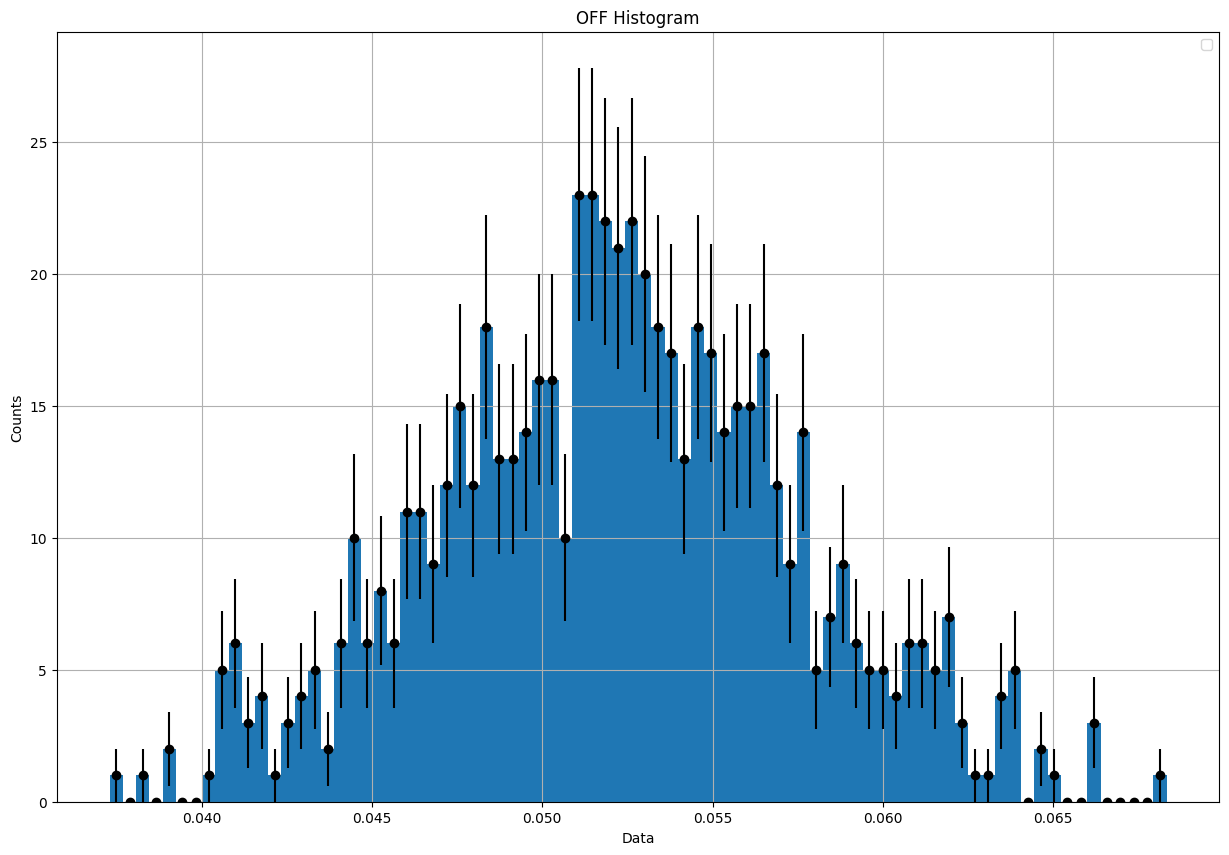

In [18]:
fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
plt.errorbar(bin_centers,hist,np.sqrt(hist),fmt='ko')
#for k in np.arange(-2,15,1):
    #plt.axvline(0.001152+k*(0.001318-0.001152)/2,0,1,linestyle='--',color='red')
plt.hist(OFF[idx],bins,density=False)
plt.title('OFF Histogram')
plt.xlabel('Data')
plt.ylabel('Counts')
plt.legend()
plt.grid()

In [227]:
A = 0.2
mu = 5
delta = 0.042
sigma = 1e-4
Egamma = 0.002
p0 = [A, mu, delta, sigma, Egamma]

C:\Users\ricca\AppData\Local\Temp\ipykernel_10296\914182456.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')


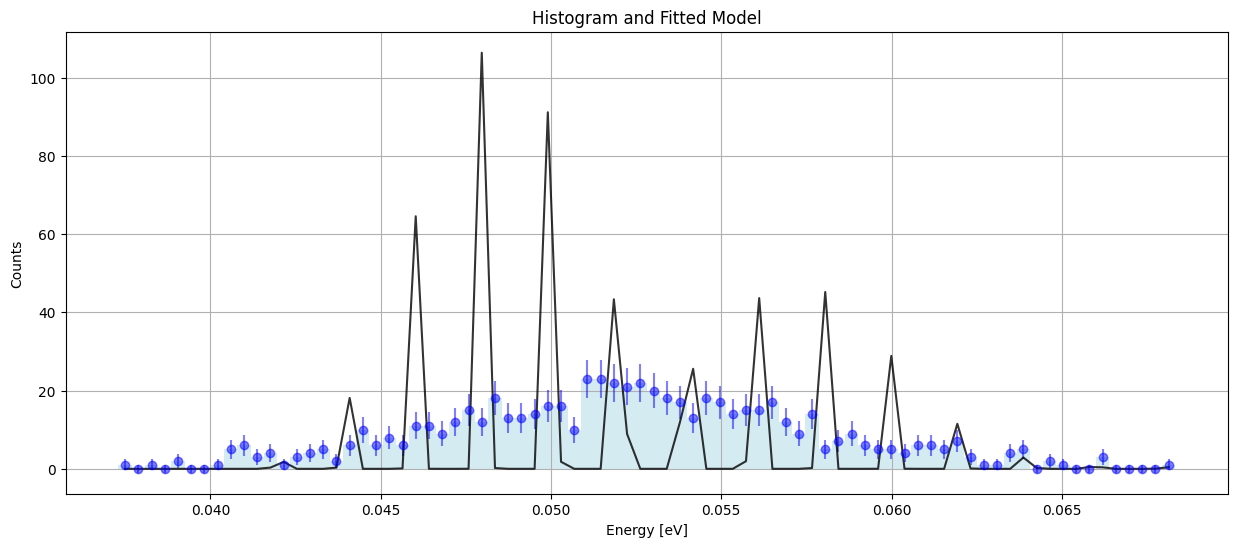

In [228]:
idx = OFF > 0.037
fig = plt.figure(figsize=(15, 6))
fig.tight_layout()
plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')
plt.plot(bin_centers, compute_sum_poisson_gaussian(bin_centers,*p0),color='black',linestyle='-', label='MIGRAD',alpha=0.8)
plt.hist(OFF[idx],80,histtype='bar',color='lightblue',density=False,alpha=0.5)
plt.xlabel('Energy [eV]')
plt.ylabel('Counts')
plt.title('Histogram and Fitted Model')
plt.grid(True)

In [217]:
model_values = compute_sum_poisson_gaussian(bin_centers, A, mu, delta, sigma, Egamma)

In [218]:
from iminuit.cost import LeastSquares
from iminuit import minuit

In [219]:
lsq = LeastSquares(bin_centers,hist,np.sqrt(hist+1),compute_sum_poisson_gaussian)
m = minuit.Minuit(lsq, *p0)
#m.fixed['Egamma'] = True
#m.fixed['sigma'] = True
m.migrad(ncall=1000);

C:\Users\ricca\AppData\Local\Temp\ipykernel_10296\1819618447.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')
C:\Users\ricca\AppData\Local\Temp\ipykernel_10296\1819618447.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(bin_centers, func(bin_centers,*m.values),np.sqrt(func(bin_centers,*m.values)), fmt='ko',color='black',linestyle='-', label='MIGRAD',alpha=0.8)


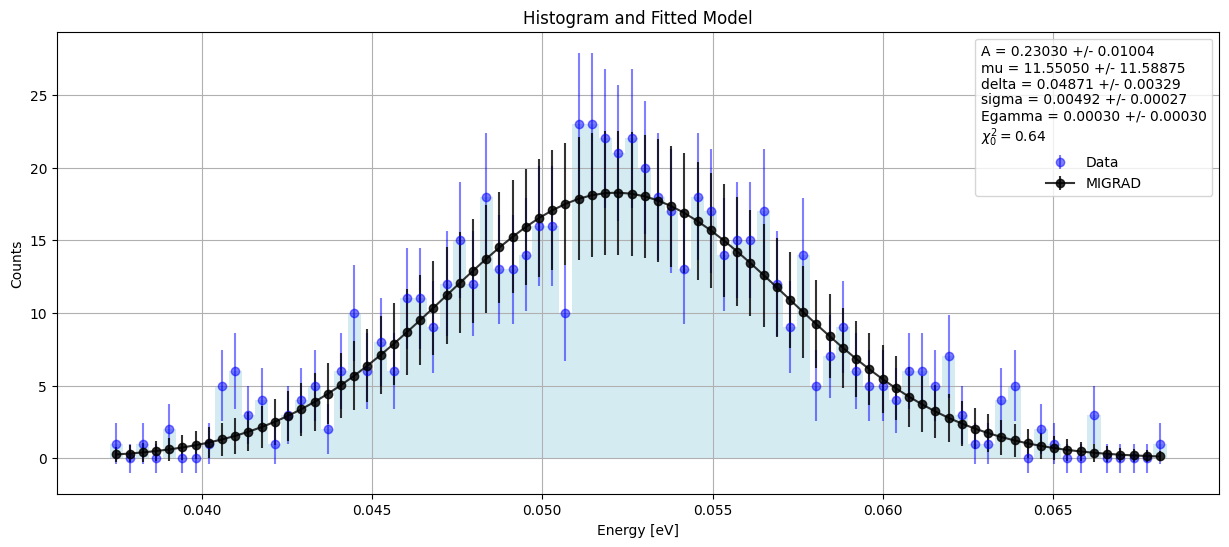

In [220]:
plot(OFF,bin_centers,hist,m,compute_sum_poisson_gaussian)

In [47]:
y = compute_sum_poisson_gaussian(OFF,*m.values)

In [48]:
m.values

<ValueView A=0.22832457238251477 mu=5.149520629158527 delta=0.04097250553345626 sigma=0.0009862952556538638 Egamma=0.0022247104679283683>

In [49]:
Num = 0
Den = 0
for val in y:
    Num += pow((val-m.values['mu']),3) 
    Den += pow((val-m.values['mu']),2) 

In [50]:
Den = pow(Den,1.5)

In [51]:
F = np.sqrt(len(y))*Num/Den

In [52]:
print(f'Skewness: {F:.2f}')

Skewness: 1.20
